In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("DailyDelhiClimateTest.csv")
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)
df.head()

C:\Users\IIMKP\AppData\Local\Temp\ipykernel_17036\3447306969.py:2: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  df['date'] = pd.to_datetime(df['date'])


,meantemp,humidity,wind_speed,meanpressure
date,,,,
2017-01-01,15.913043,85.869565,2.743478,59.000000
2017-02-01,18.500000,77.222222,2.894444,1018.277778
2017-03-01,17.111111,81.888889,4.016667,1018.333333
2017-04-01,18.700000,70.050000,4.545000,1015.700000
2017-05-01,18.388889,74.944444,3.300000,1014.333333


### Scale the Data

In [3]:
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df)

In [4]:
scaled_data[:5]

array([[0.20906568, 0.87239571, 0.07563979, 0.        ],
       [0.31914894, 0.76165066, 0.08406105, 0.99529809],
       [0.26004728, 0.82141587, 0.14666135, 0.99535573],
       [0.32765957, 0.66979723, 0.17613308, 0.99262352],
       [0.3144208 , 0.73247954, 0.10668393, 0.99120553]])

## Convert Time Series into Sequences

We transform the time-series data into sliding windows for LSTM input. 

Uses the last 20 days to predict the next day

X contains sequences of past climate values

y contains the future mean temperature

In [8]:
def create_sequences(data, window):
    X, y = [], []
    for i in range(len(data) - window):
        X.append(data[i:i + window])
        y.append(data[i + window, 0])
    return np.array(X), np.array(y)


X, y = create_sequences(scaled_data, 10)

In [9]:
print(X[0].shape, y[0].shape)

(10, 4) ()


In [10]:
print(X[0], y[0])

[[0.20906568 0.87239571 0.07563979 0.        ]
 [0.31914894 0.76165066 0.08406105 0.99529809]
 [0.26004728 0.82141587 0.14666135 0.99535573]
 [0.32765957 0.66979723 0.17613308 0.99262352]
 [0.3144208  0.73247954 0.10668393 0.99120553]
 [0.35396518 0.78849326 0.40689493 0.98854878]
 [0.15780142 1.         0.48275061 0.98813612]
 [0.19932811 0.84238611 0.03137763 0.99246789]
 [0.15197568 0.80759262 0.28757844 0.99288538]
 [0.04728132 0.69405905 0.44478755 0.99385705]] 0.0


In [11]:
scaled_data[:10]

array([[0.20906568, 0.87239571, 0.07563979, 0.        ],
       [0.31914894, 0.76165066, 0.08406105, 0.99529809],
       [0.26004728, 0.82141587, 0.14666135, 0.99535573],
       [0.32765957, 0.66979723, 0.17613308, 0.99262352],
       [0.3144208 , 0.73247954, 0.10668393, 0.99120553],
       [0.35396518, 0.78849326, 0.40689493, 0.98854878],
       [0.15780142, 1.        , 0.48275061, 0.98813612],
       [0.19932811, 0.84238611, 0.03137763, 0.99246789],
       [0.15197568, 0.80759262, 0.28757844, 0.99288538],
       [0.04728132, 0.69405905, 0.44478755, 0.99385705]])

## Split into Testing and Training Sets

In [12]:
split = int(0.85 * len(X))

X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

In [13]:
print(X_train.shape[1], X_train.shape[2])

10 4


## Multivariate Simple RNN Model

In [23]:
model_rnn = keras.Sequential()
model_rnn.add(keras.layers.SimpleRNN(100, input_shape=(X_train.shape[1], X_train.shape[2]),return_sequences=False))
model_rnn.add(keras.layers.Dropout(0.2))
model_rnn.add(keras.layers.Dense(1))
model_rnn.compile(optimizer="adam", loss="mse", metrics=["mae"])
model_rnn.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 100)               10500     
                                                                 
 dropout_1 (Dropout)         (None, 100)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 101       
                                                                 
Total params: 10601 (41.41 KB)
Trainable params: 10601 (41.41 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [24]:
history_rnn = model_rnn.fit(X_train, y_train, epochs=30, batch_size=16, validation_split=0.1, verbose=1)

Epoch 1/30
5/5 [==============================] - 7s 229ms/step - loss: 0.2040 - mae: 0.3833 - val_loss: 0.3702 - val_mae: 0.6046
Epoch 2/30
5/5 [==============================] - 0s 21ms/step - loss: 0.1052 - mae: 0.2620 - val_loss: 0.0193 - val_mae: 0.1262
Epoch 3/30
5/5 [==============================] - 0s 14ms/step - loss: 0.0483 - mae: 0.1795 - val_loss: 0.0082 - val_mae: 0.0819
Epoch 4/30
5/5 [==============================] - 0s 11ms/step - loss: 0.0426 - mae: 0.1683 - val_loss: 0.0081 - val_mae: 0.0783
Epoch 5/30
5/5 [==============================] - 0s 23ms/step - loss: 0.0353 - mae: 0.1478 - val_loss: 0.0176 - val_mae: 0.1029
Epoch 6/30
5/5 [==============================] - 0s 17ms/step - loss: 0.0261 - mae: 0.1339 - val_loss: 0.0085 - val_mae: 0.0658
Epoch 7/30
5/5 [==============================] - 0s 25ms/step - loss: 0.0298 - mae: 0.1331 - val_loss: 0.0090 - val_mae: 0.0620
Epoch 8/30
5/5 [==============================] - 0s 11ms/step - loss: 0.0280 - mae: 0.1389 - va

In [25]:
pred_rnn = model_rnn.predict(X_test)

1/1 [==============================] - 1s 751ms/step


In [26]:
y_test_inv = scaler.inverse_transform(np.c_[y_test, np.zeros((len(y_test), df.shape[1] - 1))])[:, 0]
pred_inv = scaler.inverse_transform(np.c_[pred, np.zeros((len(pred), df.shape[1] - 1))])[:, 0]

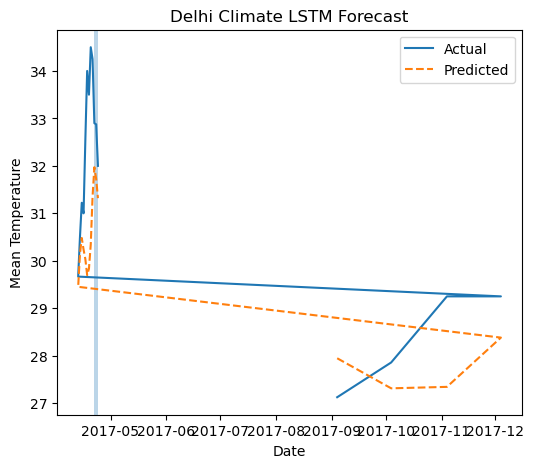

In [27]:
time = df.index[-len(y_test):]

plt.figure(figsize=(6, 5))
plt.plot(time, y_test_inv, label="Actual")
plt.plot(time, pred_inv, linestyle="--", label="Predicted")

highlight = int(len(time) * 0.85)
plt.axvspan(time[highlight], time[-1], alpha=0.3)

plt.title("Delhi Climate LSTM Forecast")
plt.xlabel("Date")
plt.ylabel("Mean Temperature")
plt.legend()
plt.show()


In [28]:
mse = mean_squared_error(y_test_inv, pred_inv)
mae = mean_absolute_error(y_test_inv, pred_inv)
r2 = r2_score(y_test_inv, pred_inv)

print("MSE:", mse)
print("MAE:", mae)
print("R²:", r2)


MSE: 4.579759331619713
MAE: 1.6570506630194524
R²: 0.07364725827452678


## LSTM

In [30]:
model = keras.Sequential()
model.add(keras.layers.LSTM(100, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=False))
model.add(keras.layers.Dropout(0.2))
model.add(keras.layers.Dense(1))
model.compile(loss="mse", optimizer="adam", metrics=["mae"])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 100)               42000     
                                                                 
 dropout_2 (Dropout)         (None, 100)               0         
                                                                 
 dense_2 (Dense)             (None, 1)                 101       
                                                                 
Total params: 42101 (164.46 KB)
Trainable params: 42101 (164.46 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


## Train the Model

In [31]:
history = model.fit(X_train, y_train, epochs=30, batch_size=16, validation_split=0.1,verbose=1)

Epoch 1/30
5/5 [==============================] - 41s 5s/step - loss: 0.0613 - mae: 0.2015 - val_loss: 0.0731 - val_mae: 0.2586
Epoch 2/30
5/5 [==============================] - 0s 17ms/step - loss: 0.0396 - mae: 0.1715 - val_loss: 0.0900 - val_mae: 0.2885
Epoch 3/30
5/5 [==============================] - 0s 15ms/step - loss: 0.0283 - mae: 0.1335 - val_loss: 0.0427 - val_mae: 0.1885
Epoch 4/30
5/5 [==============================] - 0s 13ms/step - loss: 0.0159 - mae: 0.1043 - val_loss: 0.0095 - val_mae: 0.0914
Epoch 5/30
5/5 [==============================] - 0s 13ms/step - loss: 0.0142 - mae: 0.1043 - val_loss: 0.0085 - val_mae: 0.0707
Epoch 6/30
5/5 [==============================] - 0s 12ms/step - loss: 0.0139 - mae: 0.0976 - val_loss: 0.0171 - val_mae: 0.0941
Epoch 7/30
5/5 [==============================] - 0s 13ms/step - loss: 0.0127 - mae: 0.0906 - val_loss: 0.0232 - val_mae: 0.1200
Epoch 8/30
5/5 [==============================] - 0s 13ms/step - loss: 0.0141 - mae: 0.0976 - val_

## Generate Predictions

In [32]:
pred = model.predict(X_test)

1/1 [==============================] - 1s 671ms/step


## Convert Predictions to Real Values

In [33]:
y_test_inv = scaler.inverse_transform(
    np.c_[y_test, np.zeros((len(y_test), df.shape[1] - 1))]
)[:, 0]

pred_inv = scaler.inverse_transform(
    np.c_[pred, np.zeros((len(pred), df.shape[1] - 1))]
)[:, 0]


## Plot Actual vs Predicted Values

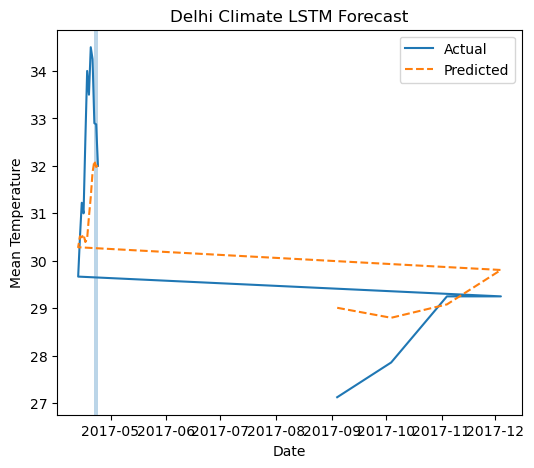

In [34]:
time = df.index[-len(y_test):]

plt.figure(figsize=(6, 5))
plt.plot(time, y_test_inv, label="Actual")
plt.plot(time, pred_inv, linestyle="--", label="Predicted")

highlight = int(len(time) * 0.85)
plt.axvspan(time[highlight], time[-1], alpha=0.3)

plt.title("Delhi Climate LSTM Forecast")
plt.xlabel("Date")
plt.ylabel("Mean Temperature")
plt.legend()
plt.show()


In [35]:
mse = mean_squared_error(y_test_inv, pred_inv)
mae = mean_absolute_error(y_test_inv, pred_inv)
r2 = r2_score(y_test_inv, pred_inv)

print("MSE:", mse)
print("MAE:", mae)
print("R²:", r2)


MSE: 2.91833403468981
MAE: 1.304188527492404
R²: 0.40970550228682867


## GRU

In [36]:
model_gru = keras.Sequential()
model_gru.add(keras.layers.GRU(100, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=False))
model_gru.add(keras.layers.Dropout(0.2))
model_gru.add(keras.layers.Dense(1))
model_gru.compile(optimizer="adam", loss="mse", metrics=["mae"])
model_gru.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 100)               31800     
                                                                 
 dropout_3 (Dropout)         (None, 100)               0         
                                                                 
 dense_3 (Dense)             (None, 1)                 101       
                                                                 
Total params: 31901 (124.61 KB)
Trainable params: 31901 (124.61 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [37]:
history_gru = model_gru.fit(X_train, y_train, epochs=30, batch_size=16, validation_split=0.1, verbose=1)

Epoch 1/30
5/5 [==============================] - 4s 185ms/step - loss: 0.0824 - mae: 0.2266 - val_loss: 0.1116 - val_mae: 0.3243
Epoch 2/30
5/5 [==============================] - 0s 21ms/step - loss: 0.0621 - mae: 0.2070 - val_loss: 0.1091 - val_mae: 0.3201
Epoch 3/30
5/5 [==============================] - 0s 12ms/step - loss: 0.0474 - mae: 0.1771 - val_loss: 0.1570 - val_mae: 0.3875
Epoch 4/30
5/5 [==============================] - 0s 11ms/step - loss: 0.0351 - mae: 0.1457 - val_loss: 0.0766 - val_mae: 0.2635
Epoch 5/30
5/5 [==============================] - 0s 11ms/step - loss: 0.0221 - mae: 0.1216 - val_loss: 0.0167 - val_mae: 0.1213
Epoch 6/30
5/5 [==============================] - 0s 12ms/step - loss: 0.0207 - mae: 0.1141 - val_loss: 0.0114 - val_mae: 0.1025
Epoch 7/30
5/5 [==============================] - 0s 12ms/step - loss: 0.0207 - mae: 0.1216 - val_loss: 0.0144 - val_mae: 0.1148
Epoch 8/30
5/5 [==============================] - 0s 13ms/step - loss: 0.0157 - mae: 0.1029 - va

In [38]:
pred_gru = model_gru.predict(X_test)

1/1 [==============================] - 0s 474ms/step


In [39]:
y_test_inv = scaler.inverse_transform(
    np.c_[y_test, np.zeros((len(y_test), df.shape[1] - 1))]
)[:, 0]

pred_rnn_inv = scaler.inverse_transform(
    np.c_[pred_rnn, np.zeros((len(pred_rnn), df.shape[1] - 1))]
)[:, 0]

pred_gru_inv = scaler.inverse_transform(
    np.c_[pred_gru, np.zeros((len(pred_gru), df.shape[1] - 1))]
)[:, 0]


In [41]:
print("RNN Results")
print("MSE:", mean_squared_error(y_test_inv, pred_rnn_inv))
print("MAE:", mean_absolute_error(y_test_inv, pred_rnn_inv))
print("R² :", r2_score(y_test_inv, pred_rnn_inv))


RNN Results
MSE: 12.169160749198006
MAE: 2.7434662233026703
R² : -1.4614689568263217


In [42]:
print("\nGRU Results")
print("MSE:", mean_squared_error(y_test_inv, pred_gru_inv))
print("MAE:", mean_absolute_error(y_test_inv, pred_gru_inv))
print("R² :", r2_score(y_test_inv, pred_gru_inv))



GRU Results
MSE: 3.827150713080468
MAE: 1.5685045473186208
R² : 0.2258781959171562


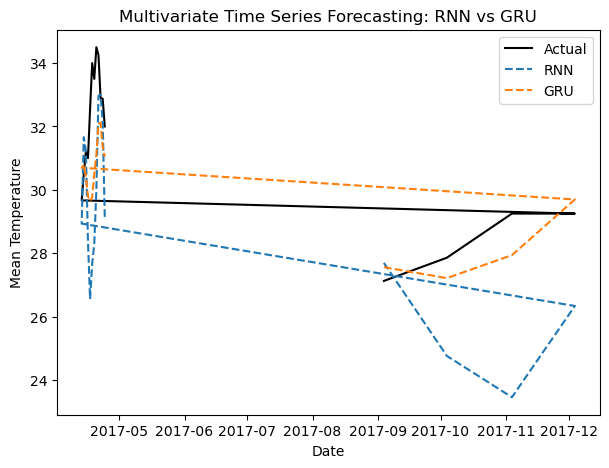

In [43]:
time = df.index[-len(y_test):]

plt.figure(figsize=(7, 5))
plt.plot(time, y_test_inv, label="Actual", color="black")
plt.plot(time, pred_rnn_inv, "--", label="RNN")
plt.plot(time, pred_gru_inv, "--", label="GRU")

plt.title("Multivariate Time Series Forecasting: RNN vs GRU")
plt.xlabel("Date")
plt.ylabel("Mean Temperature")
plt.legend()
plt.show()
